# Models training
In this notebook we train and analyze a dense model. The idea is that every frame's landmarks yield probabilities for all the words in our dictionary, but some frames are more significant than others and the probability should be high towards the actual word. The model outputs a stream of probability and another model needs to analyze it in a similar manners as done for signal processing.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [86]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from landmarks_augmentator import produce_augmentations

In [87]:
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object})
words = list(dict(Counter(data_info.word).most_common(31)).keys())

data_info = data_info.loc[data_info.word.isin(words)]

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1

def load_landmarks(filename):
    working_dir = './'
    try:
        with open(os.path.join(working_dir,'data',filename), 'rb') as file:
            lmarks = pickle.load(file)
    except FileNotFoundError:
        # If the file doesn't exist, initialize the variable
        print(f'Could not open {filename}')
        lmarks = {} # This value contains the landmarks points of all frames, in all the videos
    return lmarks


video_ids = list(data_info.video_id)
subset_landmarks = {}
for i in range(1,7):
    lmarks = load_landmarks(f'landmarks_vol{i}.pkl')
    for key, value in lmarks.items():
        if key in video_ids:
            subset_landmarks[key] = value


landmarks = {key: [] for key in subset_landmarks.keys()}

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

for key, video in subset_landmarks.items():
    new_video = np.zeros((len(video),LANDMARKS_LENGTH,3)) # frame x landdmarks x coordinates
    for i, frame in enumerate(video):
        pose = frame['pose'][:,:3] if frame['pose'].shape == (33, 4) else frame['pose'].reshape((33, 4))[:,:3]
        lh = frame['lh'] if frame['lh'].shape == (21, 3) else frame['lh'].reshape((21, 3))
        rh = frame['rh'] if frame['rh'].shape == (21, 3) else frame['rh'].reshape((21, 3))
        face = frame['face'] if frame['face'].shape == (468, 3) else frame['face'].reshape((468, 3))
        frame_landmarks = np.vstack((pose, lh, rh, face))
        new_video[i] = frame_landmarks
    landmarks[key] = new_video

del lmarks, subset_landmarks

## 0.2 Test-train split

List of hyperparameters:
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [88]:
data_info = data_info.loc[data_info.video_id.isin(landmarks.keys())]
# train, val, and test as given by the data authors, should find a better split
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

## 0.3 Produce Augmentations 
For train set only

In [89]:
# correct imbalance data by produce more augmentations for undersamples
train_landmarks = {id:video for id, video in landmarks.items() if id in train_ids}
frames_per_word = {}
for word in words:
    for id in data_info.loc[data_info.word==word,'video_id'].items():
        if id[1] in train_landmarks:
            frames_per_word[word] = frames_per_word.get(word, 0) + len(train_landmarks[id[1]])
frames_per_word = Counter(frames_per_word).most_common()
max_frames = frames_per_word[0][1]
    

In [90]:
from landmarks_augmentator import produce_augmentations, shift_hands, flip_hands, random_shift
#seed = 1
for word, frame_count in frames_per_word:
    interations = int(max_frames/frame_count)
    while interations > 0:
        video_ids = data_info.loc[(data_info.word==word)&(data_info.split=='train'),'video_id']
        for id in video_ids:
            video = train_landmarks[id]

            shift_rate = random_shift(np.random.randint(1000000)) # random_shift(seed)
            shifted_id, shifted_landmarks = shift_hands(id = id, video = video, shift_rate = shift_rate)
            #np.random.seed(seed)
            if np.random.rand() > 0.5:
                train_landmarks[shifted_id] = shifted_landmarks
            else:
                mirrored_shifted_id, mirrored_shifted_landmarks = flip_hands(id = shifted_id,video = shifted_landmarks)
                train_landmarks[mirrored_shifted_id] = mirrored_shifted_landmarks
            #seed += 1
        interations -= 1

In [91]:
for id, video in train_landmarks.items():
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        augmented_row.video_id = id
        data_info = pd.concat([data_info, augmented_row])
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
print(f'{len(landmarks)+len(train_landmarks)} videos in total for {len(words)} words')

/var/folders/sl/bbs_fbvd6bz2p7tm527x836m0000gn/T/ipykernel_59257/261282391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_row.video_id = id


1608 videos in total for 31 words


In [92]:
train_landmarks = produce_augmentations(train_landmarks,data_info.loc[data_info.video_id.isin(train_landmarks.keys())])
for id, video in list(landmarks.items()):
    if id in train_ids:
        del landmarks[id]

In [93]:
for id, video in train_landmarks.items():
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id.values: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        augmented_row.video_id = id
        data_info = pd.concat([data_info, augmented_row])
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
print(f'{len(landmarks)+len(train_landmarks)} videos in total for {len(words)} words')

/var/folders/sl/bbs_fbvd6bz2p7tm527x836m0000gn/T/ipykernel_59257/1995708125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_row.video_id = id


3999 videos in total for 31 words


In [94]:
data_info.loc[data_info.split=='train'].shape
frames_per_word = {}
for word in words:
    for id in data_info.loc[data_info.word==word,'video_id'].items():
        if id[1] in train_landmarks:
            frames_per_word[word] = frames_per_word.get(word, 0) + len(train_landmarks[id[1]])
frames_per_word = Counter(frames_per_word).most_common()
#frames_per_word
len(data_info)

3999

## 0.4 Prepare data
Each frame is a standalone instance and should have a corresponding label

In [95]:
import time
import sys
def progres_bar(i,total):
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write(f"[%-{50}s] %d%%" % ('#'*int(i/(total/50)), (100/total)*i))
        sys.stdout.flush()

In [96]:
exclude = 6 # Don't use first and last 3 frames
num_train_frames = sum(len(train_landmarks[id])-2*exclude for id in train_ids)
num_val_frames = sum(len(landmarks[id])-2*exclude for id in validation_ids)
num_test_frames = sum(len(landmarks[id])-2*exclude for id in test_ids)

X_train = np.zeros((num_train_frames, 543, 3))
y_train = []
X_val = np.zeros((num_val_frames, 543, 3))
y_val = []
X_test = np.zeros((num_test_frames, 543, 3))
y_test = []

train_frame_idx = 0
val_frame_idx = 0
test_frame_idx = 0

for id in train_ids:
    num_frames = len(train_landmarks[id])-2*exclude
    X_train[train_frame_idx:train_frame_idx + num_frames] = train_landmarks[id][exclude:-exclude]
    y_train.extend([data_info.loc[data_info.video_id == id, 'word'].item()] * num_frames)
    train_frame_idx += num_frames
    progres_bar(train_frame_idx, num_train_frames)

#    X_train = [frame.flatten() for frame in X_train]
print('')

for id in validation_ids:
    num_frames = len(landmarks[id])-2*exclude
    X_val[val_frame_idx:val_frame_idx + num_frames] = landmarks[id][exclude:-exclude]
    y_val.extend([data_info.loc[data_info.video_id == id, 'word'].item()] * num_frames)
    val_frame_idx += num_frames
    progres_bar(val_frame_idx, num_val_frames)

#    X_val = [frame.flatten() for frame in X_val]
print('')

for id in test_ids:
    num_frames = len(landmarks[id])-2*exclude
    X_test[test_frame_idx:test_frame_idx + num_frames] = landmarks[id][exclude:-exclude]
    y_test.extend([data_info.loc[data_info.video_id == id, 'word'].item()] * num_frames)
    test_frame_idx += num_frames
    progres_bar(test_frame_idx, num_test_frames)

#    X_test = [frame.flatten() for frame in X_test]

del landmarks, train_landmarks


[                                                  ] 0%

[##################################################] 100%
[##################################################] 100%
[################################################# ] 100%

In [58]:
# Suffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]

In [59]:
X_train = np.array([frame.flatten() for frame in X_train])
X_val = np.array([frame.flatten() for frame in X_val])
X_test = np.array([frame.flatten() for frame in X_test])


## 1.2 LSTM

In [84]:
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout


MODEL_VERSION = 6

def load_tf_model(folder_path):
    if not os.path.exists(folder_path):
        return False
    for file in os.listdir(folder_path):
        if file.endswith('.keras'):
            return keras.saving.load_model(os.path.join(folder_path,file))
    return False
folder_path = os.path.join('sign-to-text-interface','serving','nn',str(MODEL_VERSION))
model = load_tf_model(folder_path)

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))
y_val_categorical = to_categorical([index_to_word[word] for word in y_val], num_classes=len(words))
if not model:    
    input_shape = (X_train[0].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.64))
    model.add(Dense(512 , activation = 'relu'))
    model.add(Dropout(0.64))
    model.add(Dense(256 , activation = 'relu'))
    model.add(Dropout(0.64))
    model.add(Dense(128 , activation = 'relu'))
    model.add(Dense(len(words), activation='softmax'))
    
    model.build(input_shape=(None, *input_shape))
    
    adam_optimizer = Adam(lr=0.0002)
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1024)              1669120   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)              

In [85]:
# If the training was fast I would use this cell.
from keras.callbacks import ModelCheckpoint

last_filepath = "model_6_2_31_e1.h5"
filepath = "model_6_2_31_e2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

if os.path.exists(last_filepath):
    print('loaded weights and procceed training')
    model.load_weights(last_filepath)
history = model.fit(X_train, y_train_categorical,verbose=1, epochs=40, batch_size=16, callbacks=callbacks_list, validation_data = (X_val, y_val_categorical))

loaded weights and procceed training
Epoch 1/40
14379/14383 [============================>.] - ETA: 0s - loss: 2.3831 - categorical_accuracy: 0.3046
Epoch 1: val_categorical_accuracy improved from -inf to 0.16633, saving model to model_6_2_31_e2.h5
14383/14383 [==============================] - 152s 11ms/step - loss: 2.3831 - categorical_accuracy: 0.3046 - val_loss: 3.4289 - val_categorical_accuracy: 0.1663
Epoch 2/40
14383/14383 [==============================] - ETA: 0s - loss: 2.2379 - categorical_accuracy: 0.3263
Epoch 2: val_categorical_accuracy improved from 0.16633 to 0.19143, saving model to model_6_2_31_e2.h5
14383/14383 [==============================] - 155s 11ms/step - loss: 2.2379 - categorical_accuracy: 0.3263 - val_loss: 3.3553 - val_categorical_accuracy: 0.1914
Epoch 3/40
14382/14383 [============================>.] - ETA: 0s - loss: 2.1816 - categorical_accuracy: 0.3391
Epoch 3: val_categorical_accuracy did not improve from 0.19143
14383/14383 [========================

KeyboardInterrupt: 

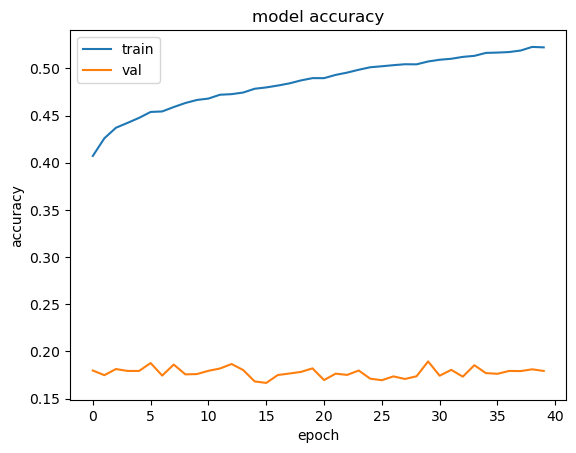

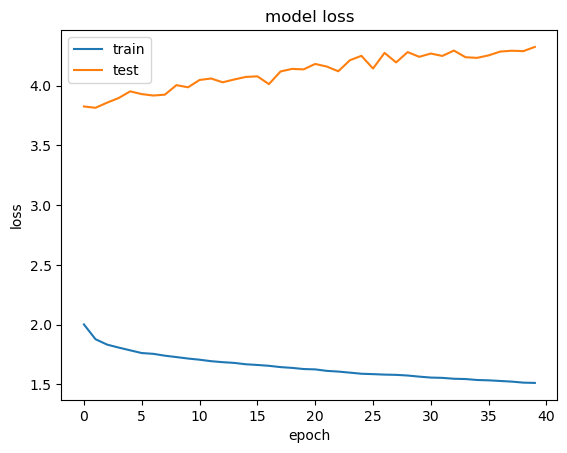

In [81]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's find how many correctly classified instances we get

In [66]:
print_acc = 'val'
count_train = Counter(y_train)
def pred_stats(X = X_test,y = y_test):
    correct = {}
    pred = model.predict(X)
    for i,j in enumerate(pred.argmax(axis=1)):
        if y[i] == words[j]:
            correct[y[i]] = correct.get(y[i],0) + 1
    count_test = Counter(y)
    pred_stats = []
    for word in words:
        row_data = {"word": word, "correct_count": correct.get(word, 0), "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
        pred_stats.append(row_data)

    stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    return stats
if print_acc == 'test':
    stats = pred_stats(X = X_test,y = y_test)
else:
    stats = pred_stats(X = X_val,y = y_val)

stats = stats.loc[:,['word','correct_count','appeared_test']]
stats = stats.sort_values('appeared_test',ascending=False).reset_index(drop=True)
not_in_test = np.sum((stats.appeared_test==0))
if not_in_test>0:
    stats.loc[:,'ratio'] = (100000 * stats.correct_count[:-not_in_test] / stats.appeared_test[:-not_in_test]).astype(int)/1000
else:
    stats.loc[:,'ratio'] = (100000 * stats.correct_count / stats.appeared_test).astype(int)/1000
stats = stats.sort_values('ratio',ascending=False).reset_index(drop=True)

display(stats)
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

217/217 [==============================] - 1s 4ms/step


,word,correct_count,appeared_test,ratio
0,table,136,285,47.719
1,black,57,123,46.341
2,many,99,236,41.949
3,help,100,241,41.493
4,orange,92,230,40.000
5,like,109,277,39.350
6,now,57,150,38.000
7,clothes,87,264,32.954
8,computer,88,346,25.433
9,yes,66,281,23.487


The mean and median amount of instances per word in the train set are: 7423.4838709677415 7160.0


In [67]:
model.save('/Users/oren/Documents/School/ai/sign_to_text/sign-to-text-interface/serving/landmark_nn/7/sign_to_text.keras')